In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import pandas as pd
import os
import datetime as dt
from sampler import Sampler, STRATEGY, STRATEGIES
import matplotlib.pyplot as plt
import statsmodels.api as sm
import numpy as np
import json
from pathlib import Path
from tqdm import tqdm
from win10toast import ToastNotifier
import seaborn as sns
toaster = ToastNotifier()

c:\users\albert\projekte\swmmpulse\venv\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Evaluation of strategies by correlation
f"samplingtime={strategy.get('samplingtime').strftime('%H:%M')}"
## Strategies

|Virtual Campaign|	Sampling Campaign| Duration	|Time/ Flow	|Collection Period	|Bottles	Volume|
|---|---|---|---|---|---|
|A	|24 hours	|1 hour	|1min	|24	|250 ml|
|B	|24 hours	|1 hour 40 min	|1min	|14 |250 ml|
|C	|24 hours	|15 min	|1min	|4 samples/ bottle	|200 ml / 1L|
|D	|23 hours |20 min	|3 min	1min	|20 samples/ 24 bottles	|50 ml/ 1L|
|E	|24 hours	|Flow Weighted	|1min	|NA	|500 ml|
|F	|Grab	|Grab (9AM/ 12 (noon))	|2min	|1	|1L|
|G	|24 hours 	|Travel Time Distribution Weighted 	|1 min 	|24 	|250ml |

In [3]:
pd.DataFrame.from_dict(STRATEGIES).T

,kind,samplecount,samplingduration,volume,start-time,end-time,samplingtime
A,time,24,60,250,00:00:00,23:59:00,NaN
B,time,72,60,250,00:00:00,23:59:00,NaN
C,time,24,60,250,06:00:00,12:59:00,NaN
D,flow,24,60,200,00:00:00,23:59:00,NaN
E,flow,72,60,200,00:00:00,23:59:00,NaN
F,flow,24,60,200,06:00:00,12:59:00,NaN
G,volume,24,60,50,00:00:00,23:59:00,NaN
H,volume,72,60,250,00:00:00,23:59:00,NaN
I,volume,24,60,250,06:00:00,12:59:00,NaN
J,grab,NaN,120,1000,NaN,NaN,09:00:00


## Import timeseries and fraction of infected
### reads file-directory

In [4]:
fdir = Path(r"C:\Users\albert\Documents\SWMMpulse")
path = Path(r"C:\Users\albert\Documents\SWMMpulse\02_processed\00_run1")

files = os.listdir(path)
flist = []
for file in files:
    flist.append(file.replace(".","_").split("_") + [file])
dffiles = pd.DataFrame.from_records(flist, columns=["catchment", "infection rate", "step", "simID", "file-extension", "filename"])
dffiles["infection rate"] = dffiles["infection rate"].astype(int) * 10**(-3)
dffiles.head()

,catchment,infection rate,step,simID,file-extension,filename
0,HS120,0.002,processed,000000,json,HS120_002_processed_000000.json
1,HS120,0.002,processed,000001,json,HS120_002_processed_000001.json
2,HS120,0.002,processed,000002,json,HS120_002_processed_000002.json
3,HS120,0.002,processed,000003,json,HS120_002_processed_000003.json
4,HS120,0.002,processed,000004,json,HS120_002_processed_000004.json


### calculates real values for infection rates

In [5]:
packet_dir = Path(r"C:\Users\albert\Documents\SWMMpulse\00_packets\00_run1")
fname_start = "HS120_"
fname_mid = "_packets_"
fname_ext = ".json"
infected_rates = []

for fname in tqdm(dffiles.loc[:,"filename"].values, desc="Calculating true infection rate..."):
        fname = fname.replace("processed", "packets")
        df_p = pd.read_json(packet_dir/fname)
        rowcount, colcount = df_p.shape
        infectedcount = df_p["classification"].value_counts()["infected"]
        infected_rates.append(infectedcount/rowcount)

dffiles["infection rate"] = infected_rates
toaster.show_toast("finished calculating infection rates")
dffiles.head()

Calculating true infection rate...: 100%|██████████| 2000/2000 [08:07<00:00,  4.11it/s]


,catchment,infection rate,step,simID,file-extension,filename
0,HS120,0.002003,processed,000000,json,HS120_002_processed_000000.json
1,HS120,0.002003,processed,000001,json,HS120_002_processed_000001.json
2,HS120,0.002003,processed,000002,json,HS120_002_processed_000002.json
3,HS120,0.002003,processed,000003,json,HS120_002_processed_000003.json
4,HS120,0.002003,processed,000004,json,HS120_002_processed_000004.json


### reads all timeseries files

In [6]:
dtindex = pd.date_range("2000-01-01", periods=8640, freq="10S")
df_timeseries = pd.DataFrame(index=dtindex)

for simID, tsfile in tqdm(dffiles.loc[:,["simID", "filename"]].values, desc="reading timeseries files..."):
    df_timeseries = df_timeseries.join(pd.read_json(path/tsfile, typ="series").rename(simID))

print("----------------reading timeseries finished---------------------")
toaster.show_toast("Timeseries read", "All timeseries have been read into memory")

reading timeseries files...: 100%|██████████| 2000/2000 [01:21<00:00, 24.54it/s]


----------------reading timeseries finished---------------------


True

### Prepare sampler
read flow data, create dtindex

In [7]:
sampler = Sampler()
dtindex = pd.date_range("2000-01-01", periods=8640, freq="10S")
flows = pd.read_csv(r"C:\Users\albert\Documents\SWMMpulse\Flow\com2a_hydraulic.csv")
flows["time"] = dtindex
flows = flows.set_index("time")["flow-rate [l/s]"]

sampler.add_flows(flows)
sampler.flows.head()

2000-01-01 00:00:00    161.657272
2000-01-01 00:00:10    161.657272
2000-01-01 00:00:20    161.657272
2000-01-01 00:00:30    161.657272
2000-01-01 00:00:40    161.657272
Freq: 10S, Name: flow-rate [l/s], dtype: float64

nicht sicher was hier passiert

In [6]:
import time
fpath = os.path.join(path, dffiles["filename"].values[0])
start = time.time()
with open(fpath) as jobj:
    jdata = json.load(jobj)
    stest = pd.Series(jdata)
    #dftest = pd.DataFrame({"scen":jdata})
print(f"json: {time.time()-start} sekuden")

start = time.time()
dfts = pd.read_json(fpath, typ="Series")
print(f"pandas: {time.time()-start} sekuden")
print(stest.head())
print(dfts.head())

json: 0.01703810691833496 sekuden
pandas: 0.017000436782836914 sekuden
946684800000    0.0
946684810000    0.0
946684820000    0.0
946684830000    0.0
946684840000    0.0
dtype: float64
2000-01-01 00:00:00    0.0
2000-01-01 00:00:10    0.0
2000-01-01 00:00:20    0.0
2000-01-01 00:00:30    0.0
2000-01-01 00:00:40    0.0
dtype: float64


In [7]:
df_timeseries = pd.read_parquet(r"aggregated_results\aggregated_timeseries_ts3.parquet", engine="pyarrow")
df_infected = pd.read_parquet(r"aggregated_results\infected_rates.parquet", engine="pyarrow")

dtindex = pd.date_range(dt.datetime.today().date(), periods=8640, freq="10S")
df_timeseries.rename(columns={c:int(c) for c in df_timeseries.columns}, inplace=True)
df_timeseries["time"] = dtindex
df_timeseries.set_index("time", inplace=True)
df_timeseries.head()

ImportError: Missing optional dependency 'pyarrow'. pyarrow is required for parquet support. Use pip or conda to install pyarrow.

## Sample Timeseries
### Prepare linear regression algorithm

In [8]:
def linreg_samples(df):
    # Prepare Data
    X = df["infection rate"].values
    X = sm.add_constant(X)
    y = df["concentration"].values
    # Fit model and extract data
    model = sm.OLS(y, X)
    results = model.fit()
    const, beta = results.params
    # calculate additional series prediction and errors
    df["pred_concentration"] = df["infection rate"] * beta + const
    df["errors"] = df["concentration"] - df["pred_concentration"]
    standard_error = np.std(df["errors"])
    pcc = df["infection rate"].corr(df["concentration"])
    df["pred_concentration_upper"] = df["pred_concentration"] + standard_error
    df["pred_concentration_lower"] = df["pred_concentration"] - standard_error
    return df, standard_error, pcc

### Plotting algorithms

In [9]:
def triple_plots(title=None):
    fig, axs = plt.subplots(ncols=3, nrows=1, figsize=[8.5,4], facecolor="white", constrained_layout=True)
    fig.suptitle(title)
    return fig, axs

def prep_axs(ax, axttl=None):
    ax[0].set(title=axttl[0], ylabel="sample concentrations [cp/l]")
    ax[1].set(title=axttl[1], xlabel="Fraction of shedding people in the catchment [-]")
    ax[2].set(title=axttl[0])
    return ax

In [10]:
def plot_samples(df, ax, ylim=[0, 8]):
    # plot data
    # plot linear regression
    ax.plot("infection rate", "pred_concentration", data=df, linewidth=2, zorder=10, linestyle="dashed")
    # plot samples
    ax.scatter(x="infection rate", y="concentration", data=df, alpha=0.3, marker="+", s=30, zorder=5, linewidths=1)
    # plot area between standard error
    ax.fill_between(df["infection rate"], df["pred_concentration_upper"], df["pred_concentration_lower"],
                    alpha=0.2, zorder=0)
    # prepare legend
    # prepare text
    standard_error = np.std(df["errors"])
    pcc = df["infection rate"].corr(df["concentration"])
    textstr = f"{'RMSE:':<5}{standard_error:>6.2f}\n{'PCC:':<5}{pcc:>8.2f}"
    # these are matplotlib.patch.Patch properties
    props = dict(boxstyle='square', facecolor='mistyrose', alpha=0.5)
    # place a text box in upper left in axes coords
    ax.text(0.05, 0.95, textstr, transform=ax.transAxes, fontsize=9,
            verticalalignment='top', bbox=props, zorder=15)
    # additional ax settings
    ax.set(xlim=[0.002,0.01], ylim=ylim, xticks=np.arange(0.002, 0.012, 0.002))

### Accuracy depending on weighting method

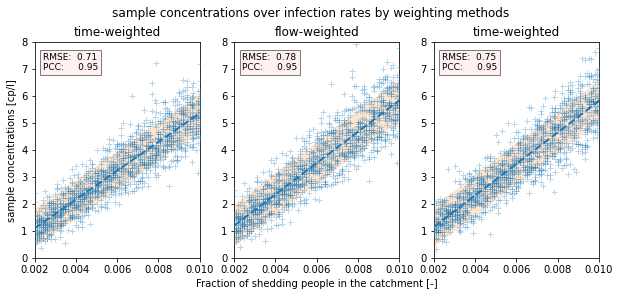

In [262]:
fig, ax = triple_plots("sample concentrations over infection rates by weighting methods")

selected_strategies = ["B", "E", "H"]

for k, name in enumerate(selected_strategies):
    # get strategy
    strategy = STRATEGIES.get(name)
    # sample timeseries
    df_samples = pd.DataFrame(sampler.sample(df_timeseries, strategy))
    # link sample concentrations to corresponding infection rates
    df_samples = df_samples.join(dffiles.set_index("simID")["infection rate"])
    # regression analysis
    df_samples, standard_error, pcc = linreg_samples(df_samples)
    # plot data
    plot_samples(df_samples, ax[k])

axttl = ["time-weighted", "flow-weighted", "volume-weighted"]
ax = prep_axs(ax, axttl)

fdir = Path(r"C:\Users\albert\Documents\SWMMpulse")
plt.savefig(fdir/"plots"/"grfk_weighting_method"/"impact_weighting_method.png", dpi=300)
plt.savefig(fdir/"plots"/"grfk_weighting_method"/"impact_weighting_method.svg")

### Accuracy depending on number of samples

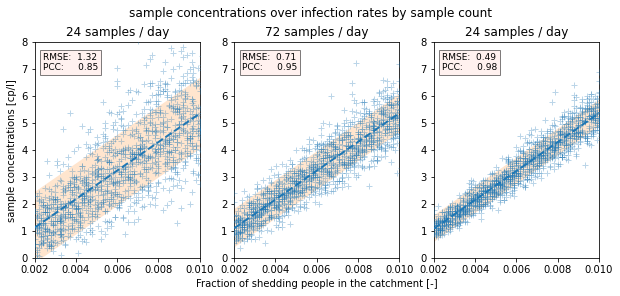

In [259]:
axttl = ["24 samples / day", "72 samples / day", "144 samples / day"]
title = "sample concentrations over infection rates by sample count"
fig, ax = triple_plots(title=title)

selected_strategies = ["A", "B", "L"]
sL = {"kind":"time",
    "samplecount":144,
    "samplingduration":60,
    "volume":250,
    "start-time":dt.time(hour=0, minute=0),
    "end-time":dt.time(hour=23, minute=59)}
STRATEGIES["L"] = sL
STRATEGIES["A"]["samplecount"] = 24

for k, name in enumerate(selected_strategies):
    # get strategy
    strategy = STRATEGIES.get(name)
    # sample timeseries
    df_samples = pd.DataFrame(sampler.sample(df_timeseries, strategy))
    # link sample concentrations to corresponding infection rates
    df_samples = df_samples.join(dffiles.set_index("simID")["infection rate"])
    # linear regression on data
    df_samples, standard_error, pcc = linreg_samples(df_samples)
    # plot data
    plot_samples(df_samples, ax[k])
    #df_samples.plot(x="infection rate",y="concentration", kind="scatter", ax=ax[k], alpha=0.1)
    #ax[k].set(xlabel="infection Rate [-]", ylabel="sample concentrations [cp/l]", xlim=[0.002,0.01], ylim=[0,8])

ax = prep_axs(ax, axttl)

fdir = Path(r"C:\Users\albert\Documents\SWMMpulse")
plt.savefig(fdir/"plots"/"grfk_samplecount"/"impact_samplecount.png", dpi=300)
plt.savefig(fdir/"plots"/"grfk_samplecount"/"impact_samplecount.svg")

### Accuracy depending on chosen time window

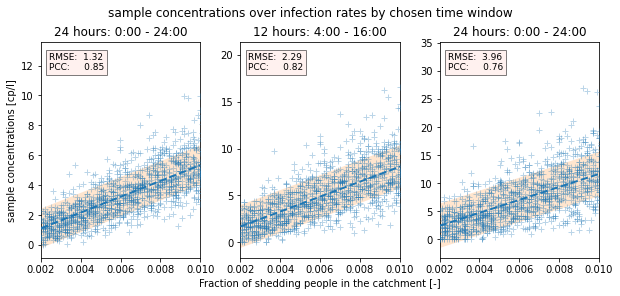

In [260]:
fig, ax = triple_plots("sample concentrations over infection rates by chosen time window")

selected_strategies = ["M", "N", "O"]

sM = {"kind":"time",
    "samplecount":24,
    "samplingduration":60,
    "volume":250,
    "start-time":dt.time(hour=0, minute=0),
    "end-time":dt.time(hour=23, minute=59)}
sN = {"kind":"time",
    "samplecount":24,
    "samplingduration":60,
    "volume":250,
    "start-time":dt.time(hour=4, minute=0),
    "end-time":dt.time(hour=15, minute=59)}
sO = {"kind":"time",
    "samplecount":24,
    "samplingduration":60,
    "volume":250,
    "start-time":dt.time(hour=5, minute=0),
    "end-time":dt.time(hour=10, minute=59)}

STRATEGIES["M"] = sM
STRATEGIES["N"] = sN
STRATEGIES["O"] = sO

for k, name in enumerate(selected_strategies):
    # get strategy
    strategy = STRATEGIES.get(name)
    # sample timeseries
    df_samples = pd.DataFrame(sampler.sample(df_timeseries, strategy))
    # link sample concentrations to corresponding infection rates
    df_samples = df_samples.join(dffiles.set_index("simID")["infection rate"])
    # linear regression
    df_samples, standard_error, pcc = linreg_samples(df_samples)
    # plot data
    plot_samples(df_samples, ax[k], ylim=None)
    #df_samples.plot(x="infection rate",y="concentration", kind="scatter", ax=ax[k], alpha=0.1)
    #ax[k].set(xlabel="infection Rate [-]", ylabel="sample concentrations [cp/l]", xlim=[0.002,0.01])

axttl = ["24 hours: 0:00 - 24:00", "12 hours: 4:00 - 16:00", "6 hours: 5:00 - 11:00"]
ax = prep_axs(ax, axttl)

fdir = Path(r"C:\Users\albert\Documents\SWMMpulse")
plt.savefig(fdir/"plots"/"grfk_sampling_period"/"impact_sampling_period.png", dpi=300)
plt.savefig(fdir/"plots"/"grfk_sampling_period"/"impact_sampling_period.svg")

## Original plots

C:\Users\alber\miniconda3\lib\site-packages\pandas\plotting\_matplotlib\tools.py:400: MatplotlibDeprecationWarning: 
The is_first_col function was deprecated in Matplotlib 3.4 and will be removed two minor releases later. Use ax.get_subplotspec().is_first_col() instead.
  if ax.is_first_col():


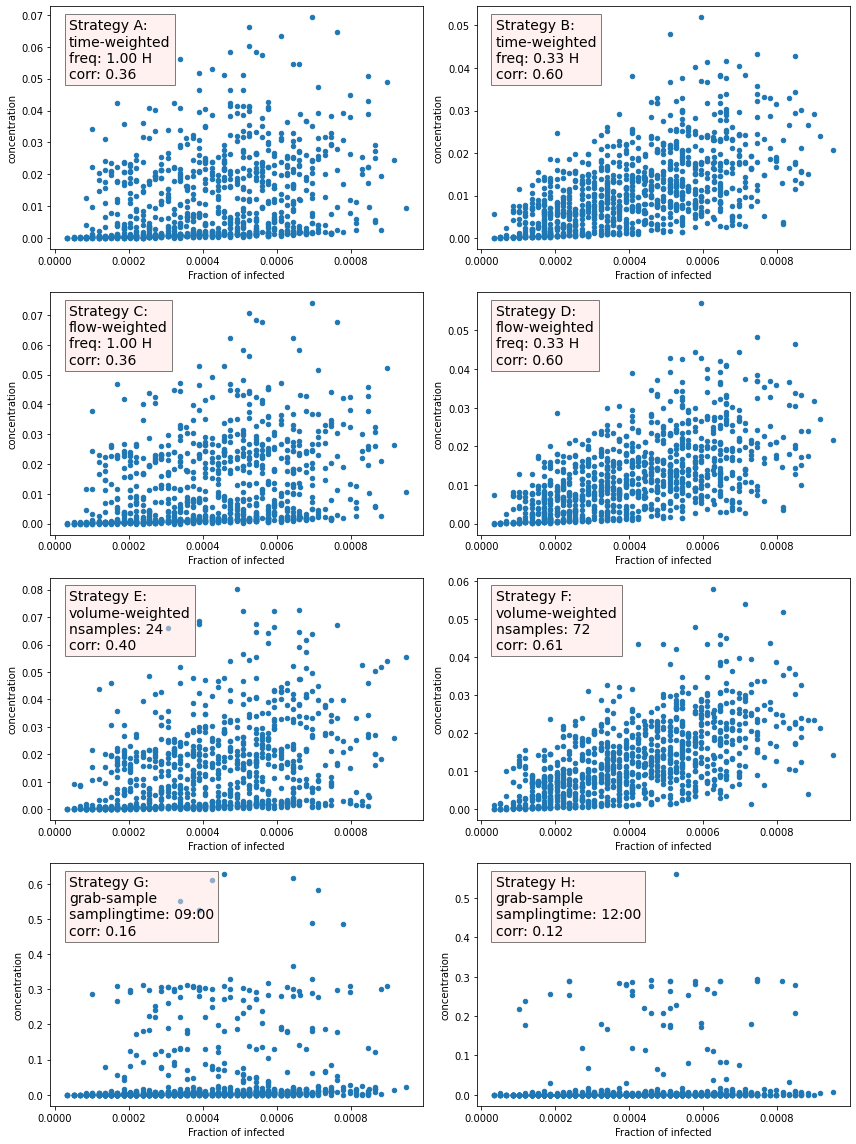

In [8]:
fig, ax = plt.subplots(ncols=2, nrows=4, figsize=[12,16], facecolor="white")

for k, (name, strategy) in enumerate(strategies.items()):
    if k < 8:
        i, j = k//2, k%2
        samples = sampler.sample(df_timeseries, strategy)
        temp = df_infected.join(samples)

        temp.plot(x="r_inf",y="concentration", kind="scatter", ax=ax[i, j])

        if strategy.get("kind") in ["time", "flow"]:
            textstr = '\n'.join([f"Strategy {name}:",
                                 f"{strategy.get('kind')}-weighted",
                                 f"freq: {float(strategy.get('samplingfreq', '0H').strip('H')):.2f} H",
                                 f'corr: {temp["r_inf"].corr(temp["concentration"]):.2f}'])
        elif strategy.get("kind") == "volume":
            textstr = '\n'.join([f"Strategy {name}:",
                                 f"{strategy.get('kind')}-weighted",
                                 f"nsamples: {strategy.get('samplecount')}",
                                 f'corr: {temp["r_inf"].corr(temp["concentration"]):.2f}'])
        elif strategy.get("kind") == "grab":
            textstr = '\n'.join([f"Strategy {name}:",
                                 f"{strategy.get('kind')}-sample",
                                 f"samplingtime: {strategy.get('samplingtime').strftime('%H:%M')}",
                                 f'corr: {temp["r_inf"].corr(temp["concentration"]):.2f}'])

        # these are matplotlib.patch.Patch properties
        props = dict(boxstyle='square', facecolor='mistyrose', alpha=0.5)

        # place a text box in upper left in axes coords
        ax[i, j].text(0.05, 0.95, textstr, transform=ax[i, j].transAxes, fontsize=14,
                verticalalignment='top', bbox=props)
        ax[i, j].set(xlabel="Fraction of infected", ylabel="concentration")

plt.tight_layout()
plt.savefig("eval_correlation.png")
plt.savefig("eval_correlation.svg")

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.linear_model import LinearRegression

ModuleNotFoundError: No module named 'sklearn'